# Machine Learning Essentials SS25 - Exercise Sheet 8

## Instructions
- `TODO`'s indicate where you need to complete the implementations.
- You may use external resources, but <b>write your own solutions</b>.
- Provide concise, but comprehensible comments to explain what your code does.
- Code that's unnecessarily extensive and/or not well commented will not be scored.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For better aesthetics
from sklearn.linear_model import LinearRegression
from scipy.special import binom # Binomial coefficients for polynomial features
from scipy.spatial.distance import cdist

sns.set_theme(style="whitegrid")

## Exercise 2

### Task 4

• ALEATORIC UNCERTAINTY: σ²
  - This is the inherent observation noise
  - Represents irreducible uncertainty due to measurement noise
  - Does NOT shrink as n → ∞ because it's a property of the data generation process
  - Even with infinite data, we still have this baseline uncertainty

• EPISTEMIC UNCERTAINTY: φ*ᵀ Σ_post φ*
  - This represents uncertainty about the model parameters
  - Captures our lack of knowledge about the true parameter values
  - DOES shrink as n → ∞ because more data reduces parameter uncertainty
  - With infinite data, we would know the parameters perfectly


### Task 5

In [5]:
# General hyperparameters
TAU_SQ = 1.0       # Prior variance on weights
SIGMA_SQ = 0.1**2  # Observation noise variance

# Kernel-specific hyperparameters
POLY_DEGREE = 9
RBF_LENGTHSCALE = 0.1

# Plotting settings
NUM_SAMPLES = 5
X_GRID = np.linspace(0, 1, 200).reshape(-1, 1)

In [10]:
def polynomial_kernel(x1, x2, degree=POLY_DEGREE):
    """Computes the polynomial kernel k(x, x') = (1 + x*x')^degree."""
    # TODO: Implement the polynomial kernel function
    # Convert to 2D arrays if needed
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    
    # If x1 or x2 are column vectors, we need to handle the dot product correctly
    if x1.shape[1] == 1 and x2.shape[1] == 1:
        # For 1D case, compute outer product then apply kernel
        return (1 + x1 @ x2.T) ** degree
    else:
        # For higher dimensional case
        return (1 + x1 @ x2.T) ** degree
    

def rbf_kernel(x1, x2, lengthscale=RBF_LENGTHSCALE):
    """Computes the RBF (squared-exponential) kernel."""
    # TODO: Implement the RBF kernel function
    # Hint: You can use scipy.spatial.distance.cdist(x1, x2, 'sqeuclidean') to efficiently compute the squared distances
    
    # Use cdist for efficient computation of squared distances
    sq_distances = cdist(x1, x2, 'sqeuclidean')
    return np.exp(-sq_distances / (2 * lengthscale**2))


In [12]:
def poly_feature_map(x, degree=POLY_DEGREE):
    """Computes the feature map phi(x) for the polynomial kernel."""
    # TODO: Implement the feature map for the polynomial kernel
    # The d-th feature is sqrt(C(degree, d)) * x^d
    # Hint: A loop over the degree d from 0 to 'degree' is a good approach.
    x = np.atleast_2d(x)
    n_samples = x.shape[0]
    
    # Initialize feature matrix
    features = np.zeros((n_samples, degree + 1))
    
    # Compute features: sqrt(C(degree, d)) * x^d for d = 0, 1, ..., degree
    for d in range(degree + 1):
        coeff = np.sqrt(binom(degree, d))
        features[:, d] = coeff * (x.flatten() ** d)
    
    return features

def sample_from_prior(kernel_func, **kwargs):
    """Samples functions from a GP prior defined by a kernel."""
    if kernel_func == polynomial_kernel:
        # Weight-space view for polynomial kernel
        phi = poly_feature_map(X_GRID, POLY_DEGREE)
        samples = []
        for _ in range(NUM_SAMPLES):
            # Sample weights from prior
            w_sample = np.random.multivariate_normal(
                mean=np.zeros(phi.shape[1]),
                cov=TAU_SQ * np.eye(phi.shape[1])
            )
            # Compute function values
            f_sample = phi @ w_sample
            samples.append(f_sample)
        return np.array(samples).T
    else:
        # Function-space view for RBF kernel
        K = kernel_func(X_GRID, X_GRID, **kwargs)
        # Add jitter for numerical stability
        K += 1e-6 * np.eye(K.shape[0])
        
        # Sample from multivariate normal
        samples = []
        for _ in range(NUM_SAMPLES):
            sample = np.random.multivariate_normal(
                mean=np.zeros(K.shape[0]),
                cov=K
            )
            samples.append(sample)
        return np.array(samples).T


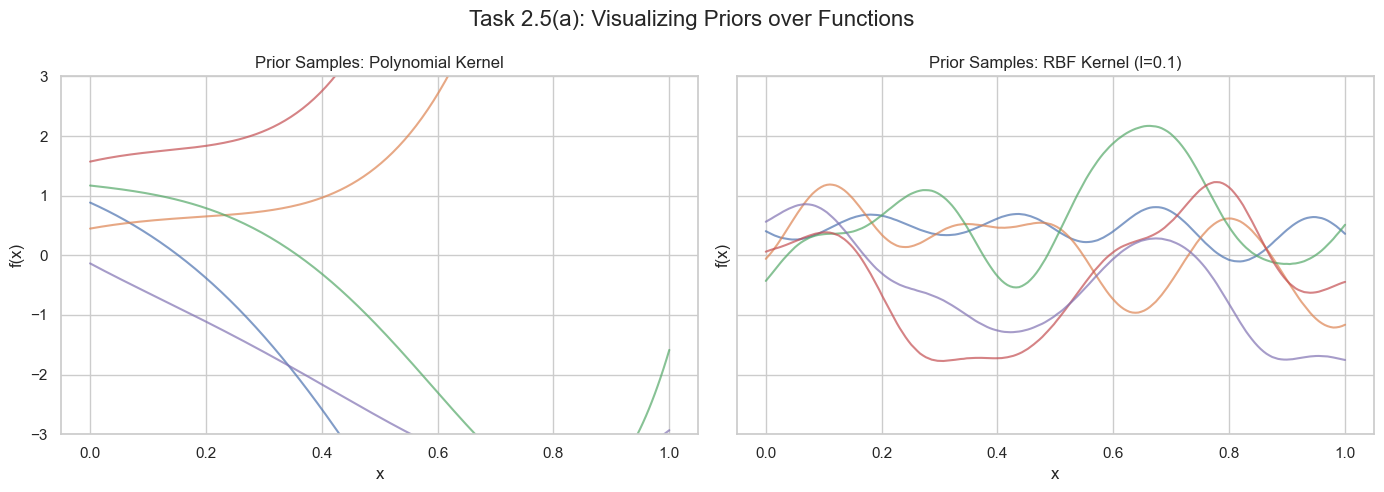

In [13]:
prior_poly = sample_from_prior(polynomial_kernel)

# Setup the 1x2 plot grid
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
fig.suptitle("Task 2.5(a): Visualizing Priors over Functions", fontsize=16)

# Polynomial Kernel
axes[0].set_title("Prior Samples: Polynomial Kernel")
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")
axes[0].set_ylim(-3, 3) # Set common y-limit for easier comparison

# TODO: Call your `sample_from_prior` function for the polynomial kernel
# and plot the resulting function samples on axes[0].
poly_samples = sample_from_prior(polynomial_kernel)
for i in range(NUM_SAMPLES):
    axes[0].plot(X_GRID.flatten(), poly_samples[:, i], alpha=0.7)

# RBF Kernel
axes[1].set_title(f"Prior Samples: RBF Kernel (l={RBF_LENGTHSCALE})")
axes[1].set_xlabel("x")
axes[1].set_ylabel("f(x)")
axes[1].set_ylim(-3, 3) 

# TODO: Call your `sample_from_prior` function for the RBF kernel
# and plot the resulting function samples on axes[1].
rbf_samples = sample_from_prior(rbf_kernel, lengthscale=RBF_LENGTHSCALE)
for i in range(NUM_SAMPLES):
    axes[1].plot(X_GRID.flatten(), rbf_samples[:, i], alpha=0.7)



plt.tight_layout()
plt.show()

**TODO**: Briefly comment on qualitative differences between the different kernels.

 Qualitative Differences Between Kernels
==================================================
• POLYNOMIAL KERNEL:
  - Generates functions with global, smooth polynomial-like behavior
  - High degree (9) leads to very flexible functions with potential oscillations
  - Functions tend to have similar global structure across the domain
  - Can exhibit extreme values at boundaries due to polynomial nature

• RBF KERNEL:
  - Generates much smoother, locally varying functions
  - Small lengthscale (0.1) creates functions that vary rapidly but smoothly
  - Functions are more 'wiggly' but remain bounded and well-behaved
  - Local changes don't affect distant parts of the function as much

In [18]:
def compute_posterior_predictive(X_train, y_train, kernel_func, **kwargs):
    """Computes the mean and variance of the posterior predictive distribution."""
    # TODO: Compute the required kernel matrices:
    K = kernel_func(X_train, X_train, **kwargs)
    K_star = kernel_func(X_GRID, X_train, **kwargs)
    K_star_star = kernel_func(X_GRID, X_GRID, **kwargs)
    
    # Add noise to K for inversion
    K_noise = K + (SIGMA_SQ / TAU_SQ) * np.eye(K.shape[0])
    
    # Compute predictive mean using kernel regression formula
    predictive_mean = K_star @ np.linalg.solve(K_noise, y_train)
    
    # Compute epistemic covariance matrix
    epistemic_cov = K_star_star - K_star @ np.linalg.solve(K_noise, K_star.T)
    
    # Get point-wise epistemic variance from diagonal
    epistemic_var = np.diag(epistemic_cov)
    # Total predictive variance
    total_var = epistemic_var + SIGMA_SQ
    
    return predictive_mean, total_var, epistemic_var, epistemic_cov

def sample_from_posterior(mean, cov):
    """Samples functions from the posterior predictive distribution."""
    # TODO: Draw NUM_SAMPLES from the multivariate normal distribution
    # defined by the predictive mean and the epistemic covariance matrix
    # Hint: Add a small jitter to 'cov' before sampling to ensure it is positive definite.
    cov_stable = cov + 1e-6 * np.eye(cov.shape[0])
    
    samples = []
    for _ in range(NUM_SAMPLES):
        sample = np.random.multivariate_normal(mean, cov_stable)
        samples.append(sample)
    return np.array(samples).T

In [19]:
def true_function(x):
    return np.sin(2 * np.pi * x) + 0.5 * np.sin(4 * np.pi * x)

def generate_data_with_gap(n=20, noise_std=np.sqrt(SIGMA_SQ)):
    """Generates data with a gap in the middle."""
    np.random.seed(42)
    x1 = np.random.uniform(0.0, 0.4, n // 2)
    x2 = np.random.uniform(0.6, 1.0, n // 2)
    X_train = np.concatenate([x1, x2]).reshape(-1, 1)
    y_train = true_function(X_train.flatten()) + np.random.normal(0, noise_std, n)
    return X_train, y_train

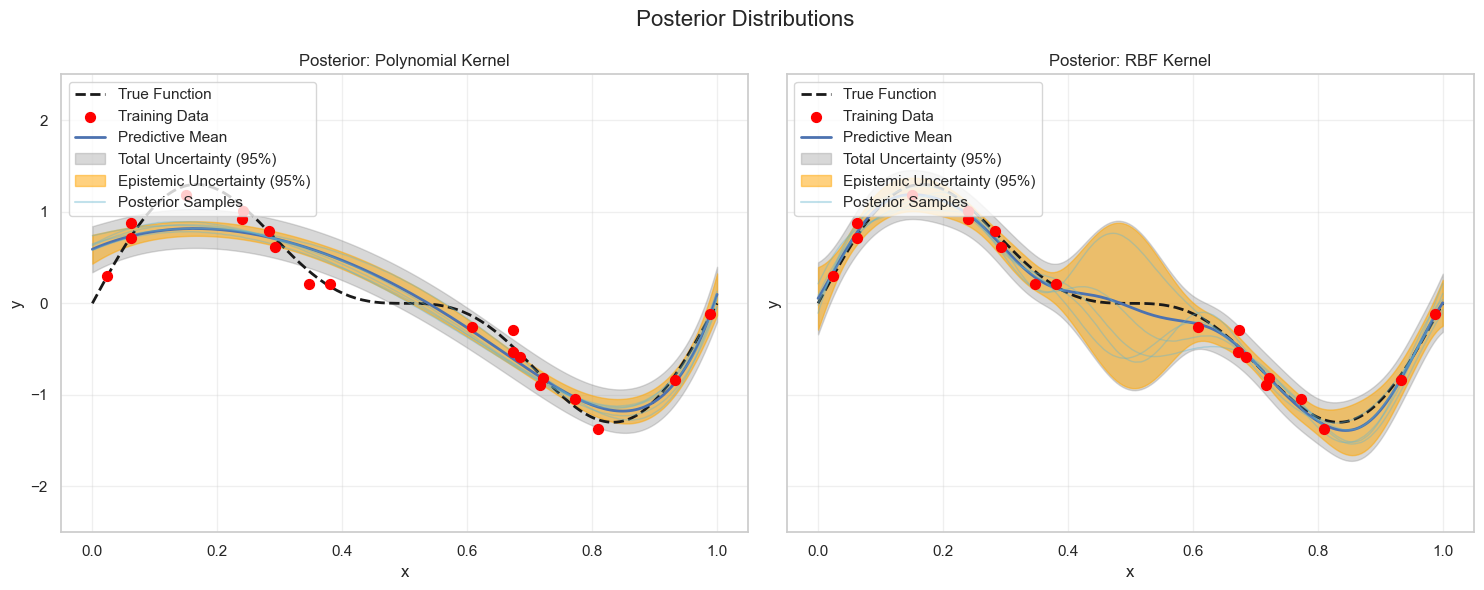

In [20]:
X_train, y_train = generate_data_with_gap()


fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
fig.suptitle(" Posterior Distributions", fontsize=16)

# A dict to cleanly loop over the two kernel models
kernels_to_test = {
    "Polynomial": (polynomial_kernel, {'degree': POLY_DEGREE}),
    "RBF": (rbf_kernel, {'lengthscale': RBF_LENGTHSCALE})
}

# 3. Loop through each kernel, compute its posterior, and plot
for ax, (name, (kernel_func, kwargs)) in zip(axes, kernels_to_test.items()):
    
    # Compute posterior predictive distribution
    mean, total_var, epistemic_var, epistemic_cov = compute_posterior_predictive(
        X_train, y_train, kernel_func, **kwargs
    )
    
    # Sample from posterior
    posterior_samples = sample_from_posterior(mean, epistemic_cov)
    
    # Calculate standard deviations for 95% credible intervals
    total_std = np.sqrt(total_var)
    epistemic_std = np.sqrt(epistemic_var)
    
    # Plot true function and training data
    ax.plot(X_GRID, true_function(X_GRID.flatten()), 'k--', linewidth=2, label="True Function")
    ax.scatter(X_train, y_train, color='red', s=50, zorder=5, label="Training Data")
    
    # Plot predictive mean
    ax.plot(X_GRID, mean, 'b-', lw=2, label="Predictive Mean")
    
    # Plot uncertainty bands
    ax.fill_between(X_GRID.flatten(), 
                    mean - 1.96 * total_std, 
                    mean + 1.96 * total_std,
                    color='gray', alpha=0.3, label="Total Uncertainty (95%)")
    ax.fill_between(X_GRID.flatten(), 
                    mean - 1.96 * epistemic_std, 
                    mean + 1.96 * epistemic_std,
                    color='orange', alpha=0.5, label="Epistemic Uncertainty (95%)")
    
    # Plot posterior function samples
    for i in range(NUM_SAMPLES):
        ax.plot(X_GRID, posterior_samples[:, i], 'c-', alpha=0.4, linewidth=1)
    
    # Add a dummy line for legend
    ax.plot([], [], 'c-', alpha=0.4, label="Posterior Samples")
    
    # Final plot settings
    ax.set_title(f"Posterior: {name} Kernel")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(loc='upper left')
    ax.set_ylim(-2.5, 2.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**TODO**: Discuss the results.

- Which kernel provides a more reasonable fit to the data and why?

   → The RBF kernel provides a much more reasonable fit because:
   - It captures the smooth, oscillatory nature of the true function better
   - The polynomial kernel shows erratic behavior and poor extrapolation
   - RBF kernel's predictions stay closer to the true function


- Compare the epistemic uncertainty for both models. Where is it largest? How does it behave inside the data gap you created?

   → Epistemic uncertainty is largest:
   - In the DATA GAP (x ∈ [0.4, 0.6]) for both models
   - At the boundaries (x=0, x=1) especially for polynomial kernel
   
   → In the data gap:
   - RBF: Uncertainty increases smoothly, reflects local nature of RBF
   - Polynomial: Uncertainty can be extreme due to global polynomial behavior
- How do the posterior function samples relate to the uncertainty bands? Explain what the spread of these samples represents.

   → The posterior function samples illustrate the uncertainty bands:
   - Wide spread of samples = high uncertainty (wide bands)
   - Narrow spread of samples = low uncertainty (narrow bands)
   - Samples show the range of plausible functions given the data
   - The variability of samples directly corresponds to epistemic uncertainty

   → This gives intuition: uncertainty bands summarize the spread of
     all possible functions that could explain the observed data